In [ ]:
import os
import cv2
import time
import random
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [ ]:
from utils.visualisation import KEYPOINT_DICT as KEYPOINT_DICT
from utils.crop import *

In [ ]:
interpreter = tf.lite.Interpreter(model_path='model\movenet_lighting.tflite')
interpreter.allocate_tensors()

In [ ]:
IMAGE_PATH = 'test3.gif'

In [ ]:
from feedback import (
    KEYPOINT_DICT, 
    calculate_angle,
    check_barbell_biceps_curl,
    check_bench_press,
    check_chest_fly_machine,
    check_decline_bench_press,
    check_hammer_curl,
    check_hip_thrust,
    check_incline_bench_press,
    check_lat_pulldown,
    check_lateral_raises,
    check_leg_extension,
    check_leg_raises,
    check_plank,
    check_pull_up,
    check_push_up,
    check_romanian_deadlift,
    check_russian_twist,
    check_shoulder_press,
    check_t_bar_row,
    check_tricep_dips,
    check_squat,
    check_tricep_pushdown,
    check_deadlift)

In [ ]:


# tflite
model_file_path = r"C:\Users\phala\Desktop\FitSaathi\model\exercise_classifier.tflite"
        
# h5
workout_model = r"C:\Users\phala\Desktop\FitSaathi\model\exercise_classifier.h5"

In [ ]:
def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores


def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

In [ ]:

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors

#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}


def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

import cv2
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
from IPython.display import HTML, display

def draw_prediction_on_image(image, keypoints_with_scores, feedback=None, crop_region=None, close_figure=False, output_image_height=None):
    """Draws the keypoint predictions on image.

    Args:
        image: A numpy array with shape [height, width, channel] representing the
        pixel values of the input image.
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
        the keypoint coordinates and scores returned from the MoveNet model.
        feedback: A list of strings representing feedback messages. The list can
        contain both positive and negative feedback.
        crop_region: A dictionary that defines the coordinates of the bounding box
        of the crop region in normalized coordinates (see the init_crop_region
        function below for more detail). If provided, this function will also
        draw the bounding box on the image.
        output_image_height: An integer indicating the height of the output image.
        Note that the image aspect ratio will be the same as the input image.

    Returns:
        A numpy array with shape [out_height, out_width, channel] representing the
        image overlaid with keypoint predictions and feedback messages.
    """
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    (keypoint_locs, keypoint_edges,
    edge_colors) = _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width)

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin,ymin),rec_width,rec_height,
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

    if feedback:
        feedback_text = '\n'.join(feedback)
        plt.text(0, 20, feedback_text, fontsize=23, color='red')

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot, dsize=(output_image_width, output_image_height),
            interpolation=cv2.INTER_CUBIC)
    return image_from_plot

def check_squat_front_facing(keypoints_with_scores):
    """Check if the form for a squat exercise is correct based on keypoints.

    Args:
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
            the keypoint coordinates and scores returned from the MoveNet model.

    Returns:
        A list of strings containing feedback messages noting the issues present
        in the form, if any.
    """
    feedback = []

    # Extract keypoint coordinates
    kpts_x = keypoints_with_scores[0, 0, :, 1]
    kpts_y = keypoints_with_scores[0, 0, :, 0]
    kpts_scores = keypoints_with_scores[0, 0, :, 2]

    # Check if left and right knees are detected
    left_knee_score = kpts_scores[11]
    right_knee_score = kpts_scores[12]
    if left_knee_score < 0.1 or right_knee_score < 0.1:
        feedback.append("Both knees are not detected.")
    else:
        feedback.append("Knees are properly detected.")

    # Check if hips are detected
    left_hip_score = kpts_scores[5]
    right_hip_score = kpts_scores[6]
    if left_hip_score < 0.1 or right_hip_score < 0.1:
        feedback.append("Both hips are not detected.")
    else:
        feedback.append("Hips are properly detected.")

    # Check if shoulders are detected
    left_shoulder_score = kpts_scores[11]
    right_shoulder_score = kpts_scores[12]
    if left_shoulder_score < 0.1 or right_shoulder_score < 0.1:
        feedback.append("Both shoulders are not detected.")
    else:
        feedback.append("Shoulders are properly detected.")

    # Check if ankles are detected
    left_ankle_score = kpts_scores[13]
    right_ankle_score = kpts_scores[14]
    if left_ankle_score < 0.1 or right_ankle_score < 0.1:
        feedback.append("Both ankles are not detected.")
    else:
        feedback.append("Ankles are properly detected.")

    # Check if knees are aligned with toes
    left_knee_x = kpts_x[11]
    right_knee_x = kpts_x[12]
    left_ankle_x = kpts_x[13]
    right_ankle_x = kpts_x[14]
    if abs(left_knee_x - left_ankle_x) > 50 or abs(right_knee_x - right_ankle_x) > 50:
        feedback.append("Knees are not aligned with toes.")
    else:
        feedback.append("Knees are aligned with toes.")

    return feedback

    import numpy as np
import math

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

def calculate_angle(p1, p2, p3):
    """Calculate the angle between three points."""
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def check_squat_front_facing(keypoints_with_scores):
    """Check if the form for a squat exercise is correct based on keypoints.

    Args:
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
            the keypoint coordinates and scores returned from the MoveNet model.

    Returns:
        A list of strings containing feedback messages noting the issues present
        in the form, if any.
    """
    feedback = []

    # Extract keypoint coordinates
    kpts_x = keypoints_with_scores[0, 0, :, 1]
    kpts_y = keypoints_with_scores[0, 0, :, 0]
    kpts_scores = keypoints_with_scores[0, 0, :, 2]

    # Check if knees are detected
    left_knee_score = kpts_scores[KEYPOINT_DICT['left_knee']]
    right_knee_score = kpts_scores[KEYPOINT_DICT['right_knee']]
    if left_knee_score < 0.1 or right_knee_score < 0.1:
        feedback.append("Both knees are not detected.")
   

    # Check if hips are detected
    left_hip_score = kpts_scores[KEYPOINT_DICT['left_hip']]
    right_hip_score = kpts_scores[KEYPOINT_DICT['right_hip']]
    if left_hip_score < 0.1 or right_hip_score < 0.1:
        feedback.append("Both hips are not detected.")
    
    # Check if ankles are detected
    left_ankle_score = kpts_scores[KEYPOINT_DICT['left_ankle']]
    right_ankle_score = kpts_scores[KEYPOINT_DICT['right_ankle']]
    if left_ankle_score < 0.1 or right_ankle_score < 0.1:
        feedback.append("Both ankles are not detected.")
    

    # Check if knees are aligned with toes
    left_knee = (kpts_x[KEYPOINT_DICT['left_knee']], kpts_y[KEYPOINT_DICT['left_knee']])
    right_knee = (kpts_x[KEYPOINT_DICT['right_knee']], kpts_y[KEYPOINT_DICT['right_knee']])
    left_ankle = (kpts_x[KEYPOINT_DICT['left_ankle']], kpts_y[KEYPOINT_DICT['left_ankle']])
    right_ankle = (kpts_x[KEYPOINT_DICT['right_ankle']], kpts_y[KEYPOINT_DICT['right_ankle']])
    left_hip = (kpts_x[KEYPOINT_DICT['left_hip']], kpts_y[KEYPOINT_DICT['left_hip']])
    right_hip = (kpts_x[KEYPOINT_DICT['right_hip']], kpts_y[KEYPOINT_DICT['right_hip']])

    
    left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
    right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
    if left_knee_angle < 150 or right_knee_angle < 150:
        feedback.append("Knees are not properly aligned with the toes.")
    else:
        feedback.append("Knees are properly aligned with the toes.")

    # Check if knees are in line with hips
    
    left_hip_knee_angle = calculate_angle(left_hip, left_knee, right_knee)
    right_hip_knee_angle = calculate_angle(right_hip, right_knee, left_knee)
    if left_hip_knee_angle < 150 or right_hip_knee_angle < 150:
        feedback.append("Hips and knees are not properly aligned.")
    else:
        feedback.append("Hips and knees are properly aligned.")

    return feedback


#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores


In [ ]:
interpreter = tf.lite.Interpreter(model_path = model_file_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

In [ ]:


# Define the mapping between exercise names and function names
exercise_function_mapping = {
    "barbell_biceps_curl": check_barbell_biceps_curl,
    "bench_press": check_bench_press,
    "chest_fly_machine": check_chest_fly_machine,
    "deadlift": check_deadlift,
    "decline_bench_press": check_decline_bench_press,
    "hammer_curl": check_hammer_curl,
    "hip_thrust": check_hip_thrust,
    "incline_bench_press": check_incline_bench_press,
    "lat_pulldown": check_lat_pulldown,
    "lateral_raises": check_lateral_raises,
    "leg_extension": check_leg_extension,
    "leg_raises": check_leg_raises,
    "plank": check_plank,
    "pull_up": check_pull_up,
    "push_up": check_push_up,
    "romanian_deadlift": check_romanian_deadlift,
    "russian_twist": check_russian_twist,
    "shoulder_press": check_shoulder_press,
    "t_bar_row": check_t_bar_row,
    "tricep_dips": check_tricep_dips,
    "squat": check_squat,
    "tricep_pushdown" : check_tricep_pushdown
}

def check_exercise_form(exercise_name, keypoints_with_scores):
    """Check the form for the given exercise based on keypoints.

    Args:
        exercise_name (str): The name of the exercise.
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
            the keypoint coordinates and scores returned from the MoveNet model.

    Returns:
        A list of strings containing feedback messages noting the issues present
        in the form, if any.
    """
    if exercise_name in exercise_function_mapping:
        # Call the corresponding function based on the exercise name
        return exercise_function_mapping[exercise_name](keypoints_with_scores)
    else:
        return ["Exercise not found in the mapping."]


In [ ]:
labels = []
with open(r'C:\Users\phala\Desktop\FitSaathi\model\workout_label.txt', 'r') as f:
    for row in f:
        labels.append(row)

video_capture = cv2.VideoCapture(IMAGE_PATH)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0
img_size = (256, 256)

fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count/fps

print(f'Duration: {duration}')
print(f'FPS: {fps}')
print(f'Total frame: {frame_count}\n')

print('Prediction process')
start_time = time.time()

# Loop through each frame in the video
while True:
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # count the frame
    n += 1
    
    if duration < 5.0:
        # predict every 10 frame (1, 11, 21, ... etc)
        step = 10
    elif duration < 10.0:
        # predict every 15 frame (1, 16, 31, ... etc)
        step = 15
    else:
        # predict every 30 frame (1, 31, 61, ... etc)
        step = 30
    
    if n % step != 1:
        continue
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
    
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frame, axis=0))

    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = f'{label}'

    
    print(f'{n}, {text}\t{results[i]}')
    
    target_frame = int(fps*2)
    
    # break the loop if prediction > 90% and video already more than 2 seconds (fps*2)
    if results[i] >= 0.9 and n >= target_frame:
        break

end_time = time.time()

print(f'Prediction: {text}')
print(f'confidence: {results[i]}')
print(f'Prediction time: {end_time - start_time} sec')

In [ ]:
exercise_name = text 
print(f'Exercise name: {exercise_name}')

In [ ]:
# Load the input image.
image_path = IMAGE_PATH
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)

In [ ]:
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    %wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    input_size = 192
  elif "movenet_thunder" in model_name:
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [20]:
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    %wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path=r"C:\Users\phala\Desktop\FitSaathi\model\movenet_lighting.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

5


['Shoulders and elbows are properly aligned.']
['Shoulders and elbows are not properly aligned.']
['Shoulders and elbows are not properly aligned.']
['Shoulders and elbows are not properly aligned.']
['Shoulders and elbows are properly aligned.']



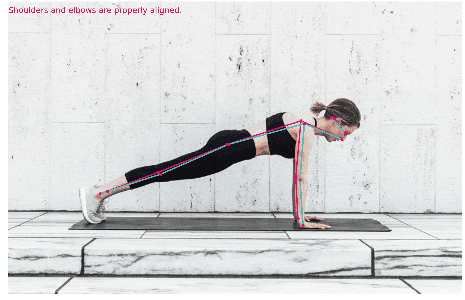

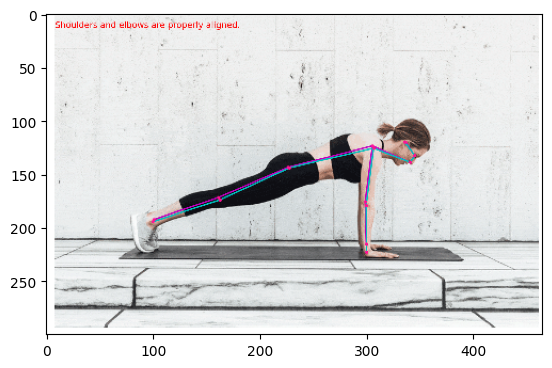

In [43]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

print(num_frames)
output_images = []
bar = display(progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):

  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])
  exercise_name = "_".join(text.split())
  feedback = check_exercise_form(exercise_name, keypoints_with_scores)
  print(feedback)
  if not feedback:
    feedback = ["All good!"]
  #print(feedback)
  #display output image 
  output_image = draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, feedback, crop_region=None,
      close_figure=True, output_image_height=300)

  # show the output image
  plt.imshow(output_image)
  output_images.append(output_image)
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
      
  
  bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, duration = 250)

In [22]:
print(text)

decline bench press

